# Временные ряды 3.  Моделируем временные ряды по ARIMA

#### 1) Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.
#### 2) Подберите параметры модели SARIMAX для этого ряда.
#### 3) Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../Lesson_2/my_PJME_MW.csv', index_col=[0], parse_dates=[0])
TARGET = 'PJME_MW'
data_m = data.resample('M').mean()

In [3]:
data_m[TARGET].values.shape

(200,)

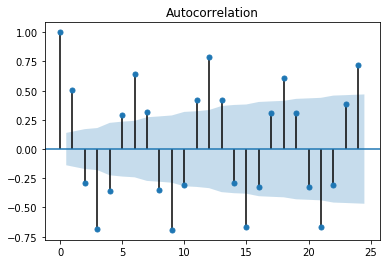

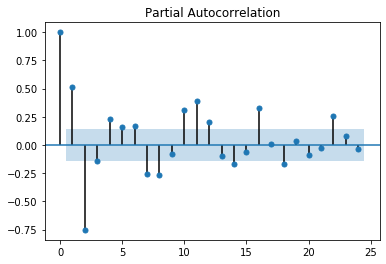

In [4]:
sm.graphics.tsa.plot_acf(data_m[TARGET].values, lags=24)
plt.show()
sm.graphics.tsa.plot_pacf(data_m[TARGET].values, lags=24)
plt.show()

Подбираем параметры

In [5]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0, 1] 
d = [0, 1]
q = range(0, 3)
s = [6, 12]
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]

In [6]:
best_aic = np.inf

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m[TARGET].values[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            if results.aic < best_aic:
                best_params = param, param_seasonal
                best_aic = results.aic
                results_opt = results
                
        except:
            continue

print('Best params: {}x{} - AIC: {}'.format(*best_params, best_aic))

Best params: (0, 1, 2)x(1, 1, 2, 12) - AIC: 2606.32018110884


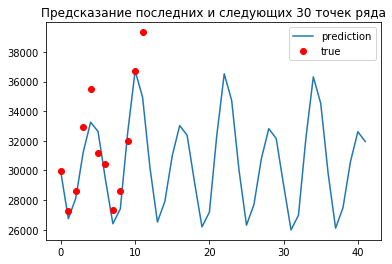

In [7]:
#pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(42)

#plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt, label='prediction' )
#Отобразим истинный значения 
plt.plot(data_m[TARGET].values[-12:],'or',label='true')
plt.title('Предсказание последних и следующих 30 точек ряда')
plt.legend()

plt.show()

По сравнению с недельной моделью предсказания по-моему неплохие

#### 4) Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )
#### 5) Оцените результат моделирования

In [12]:
covid_data = pd.read_csv('covid_19_data.csv', sep = ',', index_col=[1], parse_dates=[0])
covid_data = covid_data[(covid_data["Country/Region"] == "Russia") & (covid_data["Confirmed"] > 2)]
covid_data.tail()

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
05/01/2020,20387,NaN,Russia,2020-05-02 02:32:27,114431.0,1169.0,13220.0
05/02/2020,20710,NaN,Russia,2020-05-03 02:32:28,124054.0,1222.0,15013.0
05/03/2020,21033,NaN,Russia,2020-05-04 02:32:28,134687.0,1280.0,16639.0
05/04/2020,21356,NaN,Russia,2020-05-05 02:32:34,145268.0,1356.0,18095.0
05/05/2020,21679,NaN,Russia,2020-05-06 02:32:31,155370.0,1451.0,19865.0


In [13]:
covid_data.shape

(65, 7)

In [14]:
data_model = covid_data['Confirmed'].values

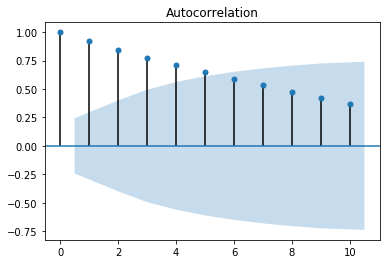

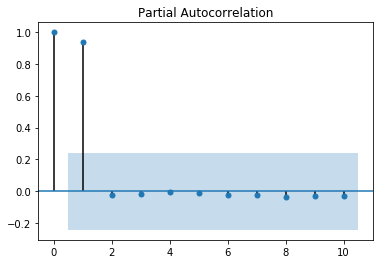

In [16]:
sm.graphics.tsa.plot_acf(data_model, lags=10)
plt.show()
sm.graphics.tsa.plot_pacf(data_model, lags=10)
plt.show()

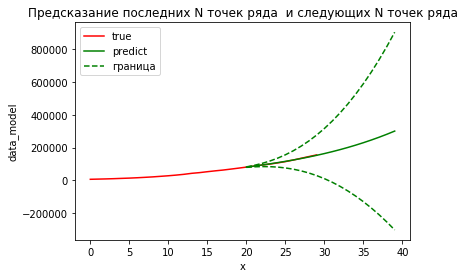

In [15]:
N = 10    # число точек для теста
# строим модель
model = ARIMA(data_model[:-N], order=(2, 2, 1))
model_fit = model.fit(disp=False)

# делаем оценку старых значений
y_p = model_fit.predict(len(data_model[:-N]), len(data_model[:-N]), typ='levels')
y_f = model_fit.forecast(2 * N)
plt.plot(data_model[-(3 * N):], 'r', label='true')
plt.plot(np.arange(2 * N) + 2 * N, y_f[0], 'g', label='predict')
plt.plot(np.arange(2 * N) + 2 * N, y_f[2][:, 1], '--g', label='граница')
plt.plot(np.arange(2 * N) + 2 * N, y_f[2][:, 0], '--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

Результат предсказания для 10 тестовых значений очень хороший